# E2E_Fraud_Detection_Pipeline_Transaction_Analysis

Import Libraries dan Setup

In [ ]:
# Data manipulation
import pandas as pd
import numpy as np
import gc
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, f1_score, accuracy_score,
    precision_score, recall_score, auc
)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb

# Class Imbalance
from imblearn.over_sampling import SMOTE

# Set random seed
np.random.seed(42)

print("✅ All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

✅ All libraries imported successfully!
Pandas version: 2.2.2
NumPy version: 2.0.2


Load and Initial Exploration

In [ ]:
print("📥 Loading datasets...")

# Load datasets
train_df = pd.read_csv('train_transaction.csv')
test_df = pd.read_csv('test_transaction.csv')

print(f"✅ Datasets loaded successfully!")
print(f"\nTraining data shape: {train_df.shape[0]:,} rows × {train_df.shape[1]} columns")
print(f"Test data shape: {test_df.shape[0]:,} rows × {test_df.shape[1]} columns")
print(f"\nMemory usage:")
print(f"  - Train: {train_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"  - Test: {test_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Display first few rows
print("\n" + "="*80)
print("SAMPLE DATA (First 3 rows)")
print("="*80)
print(train_df.head(3))

📥 Loading datasets...
✅ Datasets loaded successfully!

Training data shape: 590,540 rows × 394 columns
Test data shape: 506,691 rows × 393 columns

Memory usage:
  - Train: 2062.07 MB
  - Test: 1771.84 MB

SAMPLE DATA (First 3 rows)
   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   

   card2  card3       card4  card5  ... V330  V331  V332  V333  V334 V335  \
0    NaN  150.0    discover  142.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
1  404.0  150.0  mastercard  102.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
2  490.0  150.0        visa  166.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   

  V336  V337  V338  V339  
0  NaN   NaN   NaN   NaN  
1  NaN   NaN   NaN   NaN  
2  NaN   NaN   NaN   NaN  

[3 rows x 394 columns]


Target Variable Analysis


TARGET VARIABLE ANALYSIS

📊 Target Variable Distribution:
isFraud
0    569877
1     20663
Name: count, dtype: int64

🎯 Fraud Rate: 3.4990%
⚖️ Class Imbalance Ratio: 1:27


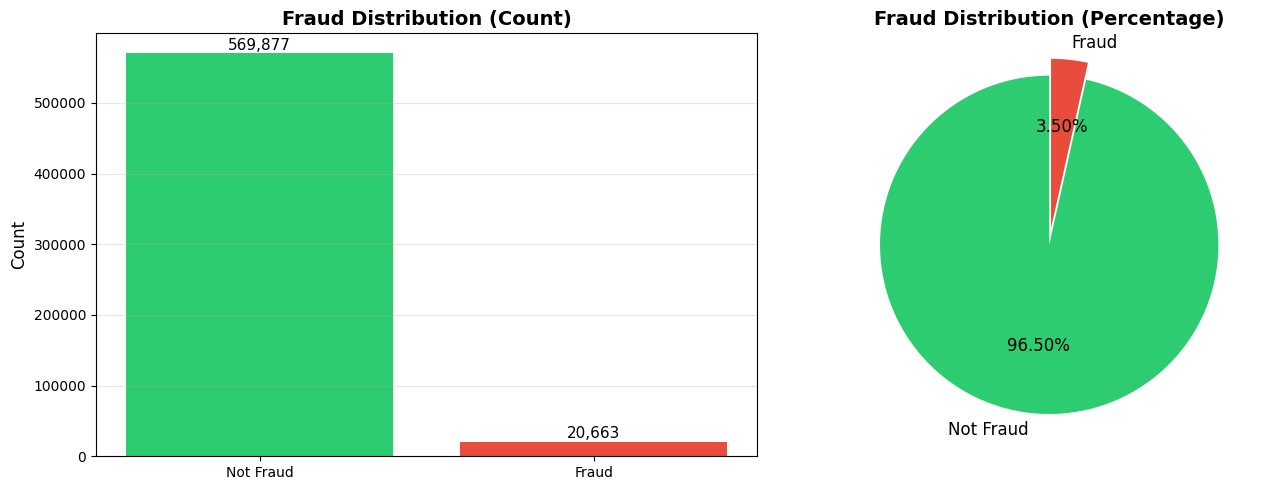

In [ ]:
print("\n" + "="*80)
print("TARGET VARIABLE ANALYSIS")
print("="*80)

# Check target distribution
print("\n📊 Target Variable Distribution:")
fraud_counts = train_df['isFraud'].value_counts()
print(fraud_counts)

fraud_rate = train_df['isFraud'].mean()
print(f"\n🎯 Fraud Rate: {fraud_rate*100:.4f}%")
print(f"⚖️ Class Imbalance Ratio: 1:{int(fraud_counts[0]/fraud_counts[1])}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
axes[0].bar(['Not Fraud', 'Fraud'], fraud_counts.values, color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Fraud Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(fraud_counts.values):
    axes[0].text(i, v + 1000, f'{v:,}', ha='center', va='bottom', fontsize=11)

# Pie chart
colors = ['#2ecc71', '#e74c3c']
explode = (0, 0.1)
axes[1].pie(fraud_counts.values, labels=['Not Fraud', 'Fraud'], autopct='%1.2f%%',
            colors=colors, explode=explode, startangle=90, textprops={'fontsize': 12})
axes[1].set_title('Fraud Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

Data Quality Check


DATA QUALITY ANALYSIS

🔍 Missing Values Analysis:

Columns with missing values: 374/394

Top 20 columns with highest missing values:
Column  Missing_Count  Missing_Percentage
 dist2         552913           93.628374
    D7         551623           93.409930
   D13         528588           89.509263
   D14         528353           89.469469
   D12         525823           89.041047
    D6         517353           87.606767
    D8         515614           87.312290
    D9         515614           87.312290
  V154         508595           86.123717
  V153         508595           86.123717
  V162         508595           86.123717
  V161         508595           86.123717
  V163         508595           86.123717
  V155         508595           86.123717
  V156         508595           86.123717
  V138         508595           86.123717
  V142         508595           86.123717
  V149         508595           86.123717
  V148         508595           86.123717
  V147         508595     

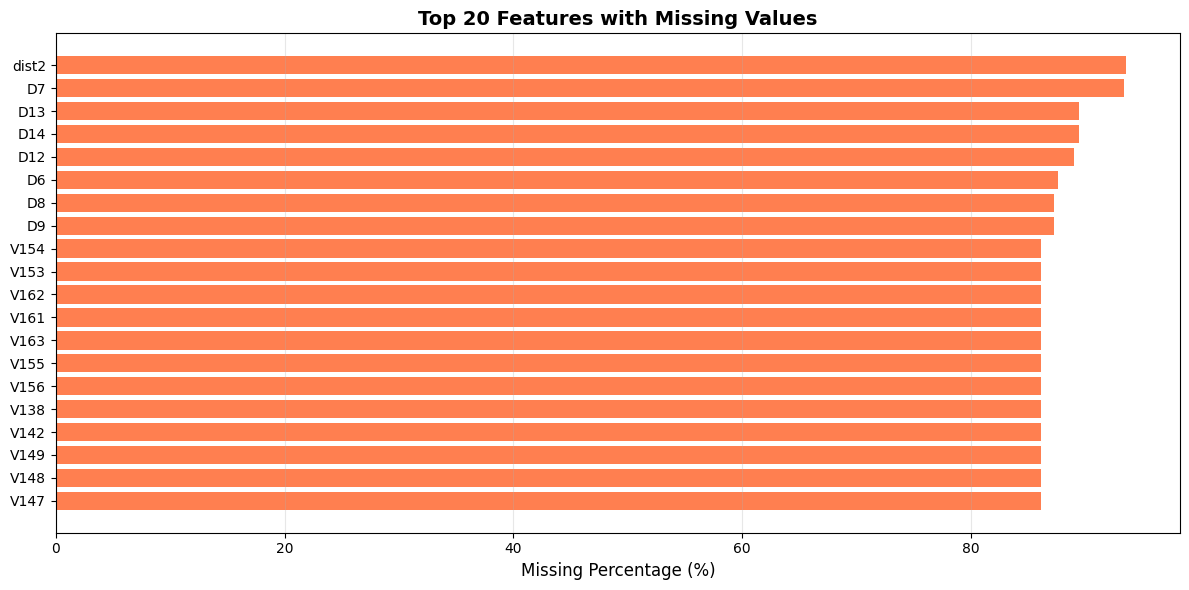


📋 Data Types Summary:
  - Numeric columns: 380
  - Categorical columns: 14
  - Total columns: 394


In [ ]:
print("\n" + "="*80)
print("DATA QUALITY ANALYSIS")
print("="*80)

# Missing values analysis
print("\n🔍 Missing Values Analysis:")
missing_train = train_df.isnull().sum()
missing_pct = (missing_train / len(train_df)) * 100

missing_df = pd.DataFrame({
    'Column': missing_train.index,
    'Missing_Count': missing_train.values,
    'Missing_Percentage': missing_pct.values
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

print(f"\nColumns with missing values: {len(missing_df)}/{len(train_df.columns)}")
print(f"\nTop 20 columns with highest missing values:")
print(missing_df.head(20).to_string(index=False))

# Visualize top missing columns
if len(missing_df) > 0:
    plt.figure(figsize=(12, 6))
    top_missing = missing_df.head(20)
    plt.barh(range(len(top_missing)), top_missing['Missing_Percentage'], color='coral')
    plt.yticks(range(len(top_missing)), top_missing['Column'])
    plt.xlabel('Missing Percentage (%)', fontsize=12)
    plt.title('Top 20 Features with Missing Values', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Data types
print("\n📋 Data Types Summary:")
print(f"  - Numeric columns: {train_df.select_dtypes(include=[np.number]).shape[1]}")
print(f"  - Categorical columns: {train_df.select_dtypes(include=['object']).shape[1]}")
print(f"  - Total columns: {train_df.shape[1]}")

Separate Features and Target

In [ ]:
print("\n" + "="*80)
print("FEATURE SEPARATION")
print("="*80)

# Store IDs and target
y_train = train_df['isFraud'].copy()
train_ids = train_df['TransactionID'].copy()
test_ids = test_df['TransactionID'].copy()

# Remove IDs and target from features
X_train = train_df.drop(['TransactionID', 'isFraud'], axis=1)
X_test = test_df.drop(['TransactionID'], axis=1)

print(f"\n✅ Features separated:")
print(f"  - X_train shape: {X_train.shape}")
print(f"  - X_test shape: {X_test.shape}")
print(f"  - y_train shape: {y_train.shape}")

# Align columns between train and test
common_cols = list(set(X_train.columns) & set(X_test.columns))
X_train = X_train[common_cols]
X_test = X_test[common_cols]

print(f"\n🔄 After alignment:")
print(f"  - Common columns: {len(common_cols)}")
print(f"  - X_train shape: {X_train.shape}")
print(f"  - X_test shape: {X_test.shape}")

# Identify column types
numerical_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

print(f"\n📊 Column Types:")
print(f"  - Numerical: {len(numerical_cols)}")
print(f"  - Categorical: {len(categorical_cols)}")


FEATURE SEPARATION

✅ Features separated:
  - X_train shape: (590540, 392)
  - X_test shape: (506691, 392)
  - y_train shape: (590540,)

🔄 After alignment:
  - Common columns: 392
  - X_train shape: (590540, 392)
  - X_test shape: (506691, 392)

📊 Column Types:
  - Numerical: 378
  - Categorical: 14


Data Cleaning

In [ ]:
print("\n" + "="*80)
print("DATA CLEANING")
print("="*80)

# Remove columns with >95% missing values
print("\n🗑️ Removing high missing columns (>95%)...")
missing_pct = X_train.isnull().sum() / len(X_train)
high_missing_cols = missing_pct[missing_pct > 0.95].index.tolist()

if high_missing_cols:
    print(f"  - Removing {len(high_missing_cols)} columns")
    print(f"  - Examples: {high_missing_cols[:5]}")
    X_train = X_train.drop(columns=high_missing_cols)
    X_test = X_test.drop(columns=high_missing_cols)
else:
    print("  - No columns with >95% missing")

print(f"\n✅ After removal: {X_train.shape[1]} columns")

# Handle missing values
print("\n🔧 Handling missing values...")

# Update column lists after removal
numerical_cols = [col for col in numerical_cols if col in X_train.columns]
categorical_cols = [col for col in categorical_cols if col in X_train.columns]

# Fill numerical with -999
for col in numerical_cols:
    if X_train[col].isnull().sum() > 0:
        X_train[col].fillna(-999, inplace=True)
        X_test[col].fillna(-999, inplace=True)

# Fill categorical with 'missing'
for col in categorical_cols:
    if X_train[col].isnull().sum() > 0:
        X_train[col].fillna('missing', inplace=True)
        X_test[col].fillna('missing', inplace=True)

print(f"✅ Missing values handled")
print(f"  - Remaining missing in train: {X_train.isnull().sum().sum()}")
print(f"  - Remaining missing in test: {X_test.isnull().sum().sum()}")

# Free memory
gc.collect()


DATA CLEANING

🗑️ Removing high missing columns (>95%)...
  - No columns with >95% missing

✅ After removal: 392 columns

🔧 Handling missing values...
✅ Missing values handled
  - Remaining missing in train: 0
  - Remaining missing in test: 4787


5088

Feature Engineering

In [ ]:
print("\n" + "="*80)
print("FEATURE ENGINEERING (Memory Optimized)")
print("="*80)

import psutil
import os

# Function to check memory usage
def check_memory():
    process = psutil.Process(os.getpid())
    mem_gb = process.memory_info().rss / 1024**3
    return mem_gb

print(f"\n💾 Initial memory usage: {check_memory():.2f} GB")
print("\n🔨 Creating new features (memory-efficient)...")

# Process each dataframe separately to avoid duplication
for df_name, df in [('Train', X_train), ('Test', X_test)]:
    print(f"\n  Processing {df_name} data...")

    # Transaction Amount features (use float32 to save memory)
    if 'TransactionAmt' in df.columns:
        df['TransactionAmt_log'] = np.log1p(df['TransactionAmt']).astype('float32')
        df['TransactionAmt_decimal'] = (df['TransactionAmt'] - df['TransactionAmt'].astype(int)).astype('float32')
        df['TransactionAmt_rounded'] = ((df['TransactionAmt'] / 100).round() * 100).astype('float32')
        print(f"    ✓ TransactionAmt features created")

    # Time features (use int16/int8 for small integers)
    if 'TransactionDT' in df.columns:
        df['Transaction_hour'] = ((df['TransactionDT'] / 3600) % 24).astype('int8')
        df['Transaction_day'] = (df['TransactionDT'] / (3600 * 24)).astype('int16')
        df['Transaction_day_of_week'] = (df['Transaction_day'] % 7).astype('int8')
        df['Transaction_is_weekend'] = df['Transaction_day_of_week'].isin([5, 6]).astype('int8')

        # For categorical bins, use category dtype (much less memory)
        df['Transaction_hour_bin'] = pd.cut(df['Transaction_hour'],
                                             bins=[0, 6, 12, 18, 24],
                                             labels=['night', 'morning', 'afternoon', 'evening'])
        df['Transaction_hour_bin'] = df['Transaction_hour_bin'].astype('category')
        print(f"    ✓ Time-based features created")

    # Card combination features (use category dtype)
    if 'card1' in df.columns and 'card2' in df.columns:
        df['card1_card2'] = (df['card1'].astype(str) + '_' + df['card2'].astype(str)).astype('category')
        print(f"    ✓ Card combination features created")

    # Address combination (use category dtype)
    if 'addr1' in df.columns and 'addr2' in df.columns:
        df['addr1_addr2'] = (df['addr1'].astype(str) + '_' + df['addr2'].astype(str)).astype('category')
        print(f"    ✓ Address combination features created")

    # Email features (boolean uses less memory than int)
    if 'P_emaildomain' in df.columns:
        df['P_emaildomain_isNull'] = df['P_emaildomain'].isnull().astype('int8')
        print(f"    ✓ Email features created")

    # Force garbage collection after each dataframe
    gc.collect()
    print(f"    💾 Memory after {df_name}: {check_memory():.2f} GB")

print(f"\n✅ Feature engineering complete!")
print(f"  - New feature count: {X_train.shape[1]}")
print(f"  - Final memory usage: {check_memory():.2f} GB")

# Optimize data types to reduce memory
print("\n🔧 Optimizing data types...")

def optimize_dtypes(df):
    """Reduce memory by downcasting numeric types"""
    for col in df.select_dtypes(include=['int']).columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')

    for col in df.select_dtypes(include=['float']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')

    return df

X_train = optimize_dtypes(X_train)
X_test = optimize_dtypes(X_test)

print(f"✅ Data types optimized!")
print(f"  - Memory usage after optimization: {check_memory():.2f} GB")

# Update column types
numerical_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"\n📊 Final column summary:")
print(f"  - Numerical: {len(numerical_cols)}")
print(f"  - Categorical: {len(categorical_cols)}")
print(f"  - Total: {X_train.shape[1]}")

# Memory usage breakdown
print(f"\n💾 Memory usage by dataframe:")
print(f"  - X_train: {X_train.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"  - X_test: {X_test.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"  - y_train: {y_train.memory_usage(deep=True) / 1024**2:.2f} MB")


FEATURE ENGINEERING (Memory Optimized)

💾 Initial memory usage: 8.30 GB

🔨 Creating new features (memory-efficient)...

  Processing Train data...
    ✓ TransactionAmt features created
    ✓ Time-based features created
    ✓ Card combination features created
    ✓ Address combination features created
    ✓ Email features created
    💾 Memory after Train: 8.34 GB

  Processing Test data...
    ✓ TransactionAmt features created
    ✓ Time-based features created
    ✓ Card combination features created
    ✓ Address combination features created
    ✓ Email features created
    💾 Memory after Test: 8.34 GB

✅ Feature engineering complete!
  - New feature count: 403
  - Final memory usage: 8.34 GB

🔧 Optimizing data types...
✅ Data types optimized!
  - Memory usage after optimization: 5.32 GB

📊 Final column summary:
  - Numerical: 386
  - Categorical: 17
  - Total: 403

💾 Memory usage by dataframe:
  - X_train: 1288.06 MB
  - X_test: 1103.49 MB
  - y_train: 4.51 MB


Encode Categorical Variables

In [ ]:
print("\n" + "="*80)
print("CATEGORICAL ENCODING")
print("="*80)

if len(categorical_cols) > 0:
    print(f"\n🔤 Encoding {len(categorical_cols)} categorical columns...")

    label_encoders = {}
    for i, col in enumerate(categorical_cols, 1):
        try:
            le = LabelEncoder()
            # Combine train and test for consistent encoding
            combined = pd.concat([X_train[col], X_test[col]], axis=0)
            le.fit(combined.astype(str))

            X_train[col] = le.transform(X_train[col].astype(str))
            X_test[col] = le.transform(X_test[col].astype(str))

            label_encoders[col] = le

            if i % 10 == 0:
                print(f"  - Encoded {i}/{len(categorical_cols)} columns...")
        except Exception as e:
            print(f"  ⚠️ Warning: Could not encode {col}: {e}")

    print(f"✅ All categorical columns encoded!")
else:
    print("✅ No categorical columns to encode")

print(f"\n📊 Final data types:")
print(f"  - Numeric columns: {len(X_train.select_dtypes(include=[np.number]).columns)}")
print(f"  - Non-numeric columns: {len(X_train.select_dtypes(exclude=[np.number]).columns)}")

gc.collect()


CATEGORICAL ENCODING

🔤 Encoding 17 categorical columns...
  - Encoded 10/17 columns...
✅ All categorical columns encoded!

📊 Final data types:
  - Numeric columns: 403
  - Non-numeric columns: 0


0